# Model with pretrained embeddings
    - Glove embeddings. Vectors of 300 dim.
    - Model: Basic LSTM.


In [1]:
# Header
from __future__ import print_function

import numpy as np
import keras
print('Keras version: ', keras.__version__)

# GPU devices visible by python
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Limit memory usage
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


path = '/home/ubuntu/data/training/keras/'

Using TensorFlow backend.


## Preprocess data

In [2]:
#Imports 
from __future__ import print_function

import numpy as np
import os
import shutil
import fnmatch

from collections import OrderedDict
from nltk import word_tokenize

data_path='/home/ubuntu/data/training/keras/aclImdb/'



# Generator of list of files in a folder and subfolders
def gen_find(filepath,top):
    for path, dirlist, filelist in os.walk(top):
        for name in fnmatch.filter(filelist,filepath):
            yield os.path.join(path,name)

def read_sentences(path):
    sentences = []
    sentences_list = gen_find("*.txt", path)
    for ff in sentences_list:
        with open(ff, 'r') as f:
            sentences.append(f.readline().strip())
    return sentences 

def tokenize(sentences):
    print( 'Tokenizing...',)
    tokens = []
    for sentence in sentences:
        tokens += [word_tokenize(sentence.decode('utf-8'))]
    print('Done!')
    return tokens

def build_dict(sentences):
    print( 'Building dictionary..',)
    wordcount = dict()
    for ss in sentences:
        for w in ss:
            if w not in wordcount:
                wordcount[w] = 1
            else:
                wordcount[w] += 1

    counts = wordcount.values()
    keys = wordcount.keys()
    sorted_idx = np.argsort(counts)[::-1]

    worddict = dict()
    for idx, ss in enumerate(sorted_idx):
        worddict[keys[ss]] = idx+2  # leave 0 and 1 (UNK)
    print( np.sum(counts), ' total words ', len(keys), ' unique words')
    return worddict, wordcount

def generate_sequence(sentences, dictionary):
    seqs = [None] * len(sentences)
    for idx, ss in enumerate(sentences):
        seqs[idx] = [dictionary[w] if w in dictionary else 1 for w in ss]
    return seqs

#Data extraction

#Extract training sentences
sentences_trn_pos = tokenize(read_sentences(data_path+'train/pos/'))
sentences_trn_neg = tokenize(read_sentences(data_path+'train/neg/'))
sentences_trn = sentences_trn_pos + sentences_trn_neg

#Build train dictionary
worddict, wordcount = build_dict(sentences_trn)

#Generate train data
train_x_pos = generate_sequence(sentences_trn_pos, worddict)
train_x_neg = generate_sequence(sentences_trn_neg, worddict)
X_train_full = train_x_pos + train_x_neg
y_train_full = [1] * len(train_x_pos) + [0] * len(train_x_neg)


#Read test sentences and generate target y
sentences_tst_pos = read_sentences(data_path+'test/pos/')
sentences_tst_neg = read_sentences(data_path+'test/neg/')

test_x_pos = generate_sequence(tokenize(sentences_tst_pos), worddict)
test_x_neg = generate_sequence(tokenize(sentences_tst_neg), worddict)
X_test_full = test_x_pos + test_x_neg
y_test_full = [1] * len(test_x_pos) + [0] * len(test_x_neg)


print('Preprocess done!')

Tokenizing... 
Done!
Tokenizing... 
Done!
Building dictionary... 
7056193  total words  135098  unique words
Tokenizing... 
Done!
Tokenizing... 
Done!
Preprocess done!


## Load embeddings and join with the current dictionary

In [3]:
#Load embeddings
import pandas as pd
import csv

embed_dim = 300

embedding_path = '/home/ubuntu/data/training/keras/'

df_glove = pd.read_csv(embedding_path + "glove.6B."+str(embed_dim)+"d.txt", index_col=0 ,sep=' ',
                   header = None, quoting=csv.QUOTE_NONE, encoding='utf-8')

#Merge with the dictionary of the current texts: Inner join, only words in the corpus and in glove.
df_glove = df_glove.merge(pd.DataFrame.from_dict(worddict, orient='index'), left_index=True, right_index=True)
print('Merged words: ', df_glove.shape[0])

#Create dictionary: word_number_id --> [glove vector associated]
glove={}
for i,r in df_glove[:].iterrows():
    glove[int(r[0])] = [r[j] for j in range(1,embed_dim+1)]
print('Dictionary length: ', len(glove))

Merged words:  45934
Dictionary length:  45934


## Prepare sequences to model


In [4]:
#Create embeddings 3D tensors
max_len = 100

def embedd(x):
    r = np.zeros((max_len, embed_dim))
    pos = max_len-1
    for i in xrange(len(x),0,-1):
        found = True
        try:
            v = np.array([glove[x[i-1]]])
        except:
            found = False
        if found and pos>=0:
            r[pos,:] = v 
            pos += -1
    return r
        
X_train = np.array([embedd(s) for s in X_train], dtype=np.float32)
print( X_train.shape)

X_test = np.array([embedd(s) for s in X_test], dtype=np.float32)
print( X_test.shape)

(25000, 100, 300)
(25000, 100, 300)


In [5]:
# Shuffle data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)

## Build model

In [6]:
# Model
num_hidden_rnn = 128 #Num of neurons in the Recurent network 


from keras.models import Model
from keras.layers import Input, Embedding, SimpleRNN, LSTM, Dropout, Dense, merge
from keras.optimizers import RMSprop

print('Build model 1 - Basic model...')

# LAYER 1: inputs
seq_prev_input = Input(shape=(max_len, embed_dim), dtype='float32') 

# LAYER 2: Create embedings
#embeds = Embedding(max_features, dim_embedings, input_length=max_len)(seq_prev_input)

# LAYERS 3: RNN - forwards LSTM with dropout
forward = LSTM(num_hidden_rnn, return_sequences=True,
                 dropout_W=0.3, dropout_U=0.3, name='Forward1')(seq_prev_input)
rnn_out = LSTM(num_hidden_rnn, return_sequences=False,
                 dropout_W=0.3, dropout_U=0.3, name='Forward2')(forward)


# LAYER 4: Dense layer to outputs - softmax activation
output = Dense(2, activation='softmax')(rnn_out)

# Model Architecture defined
model_1 = Model(input=seq_prev_input, output=output)
model_1.summary()

# Compile model and select optimizer
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


Build model 1 - Basic model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100, 300)      0                                            
____________________________________________________________________________________________________
Forward1 (LSTM)                  (None, 100, 128)      219648      input_1[0][0]                    
____________________________________________________________________________________________________
Forward2 (LSTM)                  (None, 128)           131584      Forward1[0][0]                   
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 2)             258         Forward2[0][0]                   
Total params: 351,490
Trainable params: 351,490
Non-trainabl

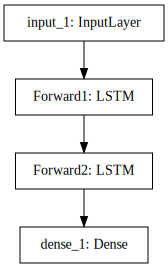

In [ ]:
#Plot the model graph
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model_1).create(prog='dot', format='svg'))

In [ ]:
# Train
batch_size = 128

print("Train...")
history = model_1.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20,
                      validation_data=(X_test, y_test))

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 155s - loss: 0.6303 - acc: 0.6340 - val_loss: 0.4947 - val_acc: 0.7670
Epoch 2/20
25000/25000 [==============================] - 98s - loss: 0.4979 - acc: 0.7612 - val_loss: 0.4131 - val_acc: 0.8099
Epoch 3/20
25000/25000 [==============================] - 90s - loss: 0.4316 - acc: 0.7988 - val_loss: 0.3855 - val_acc: 0.8247
Epoch 4/20
25000/25000 [==============================] - 93s - loss: 0.4014 - acc: 0.8166 - val_loss: 0.3627 - val_acc: 0.8359
Epoch 5/20
25000/25000 [==============================] - 100s - loss: 0.3814 - acc: 0.8284 - val_loss: 0.3515 - val_acc: 0.8433
Epoch 6/20
25000/25000 [==============================] - 95s - loss: 0.3662 - acc: 0.8358 - val_loss: 0.3466 - val_acc: 0.8430
Epoch 7/20
25000/25000 [==============================] - 97s - loss: 0.3556 - acc: 0.8406 - val_loss: 0.3425 - val_acc: 0.8479
Epoch 8/20
25000/25000 [===================

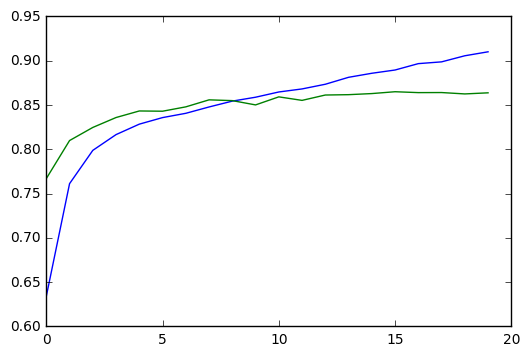

In [ ]:
#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

## Validate it

In [ ]:
# Score and obtain probabilities
pred_test = model_1.predict(X_test)
print(pred_test.shape)

(25000, 2)


Accuracy:  0.86376
AUC:  0.9413877888


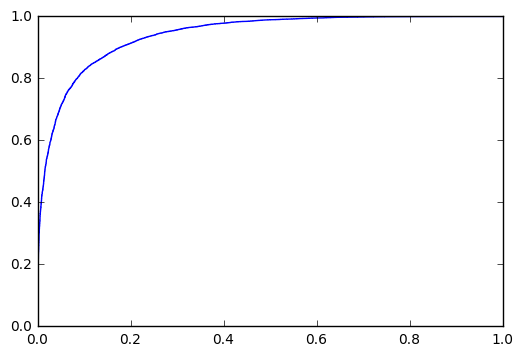

In [ ]:
#Import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score

#Calculate accuracy with sklearn
print('Accuracy: ',accuracy_score(y_test, [1 if p>0.5 else 0 for p in pred_test[:,1]]))

#Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test[:,1])
print('AUC: ', auc(fpr, tpr) ) 

#Plot ROC curve
plt.plot(fpr, tpr)

In [ ]:
#Evaluate one positive record
i = 1 # 1, 2, ... , 25000
print('Sentence: ',sentences_tst_pos[i])
print('target: ',y_test[i])
print('Prediction [neg, pos]: ', pred_test[i])

Sentence:  Inglorious Basterds makes no apologies, asks for no forgiveness, it's a no holds barred assault on the senses. Tarantino doesn't care if he offends, if he steps all over stereotypes and clichés, this is film making at it purest. It's great to see a film maker whose work clearly isn't interfeared with by the powers that be. Tarantino is a master of effortlessly cranking up immense tension and suddenly mixing it with laugh out loud moments; you're not sure if you should be looking away in disgust or rolling around laughing, either way it's a roller coaster and one not to be missed! It's not for everyone and I'm unsure how Germans will take the film, certainly if you're not a fan of Tarantino's style, this may be a little hard to swallow, but never-the-less, it is a film which simply has to be seen. No self respecting film fan should miss this. And the performance of Christoph Waltz... Oscar don't you dare ignore him!!
target:  1
Prediction [neg, pos]:  [ 0.7154929   0.28450701

In [ ]:
#Evaluate one negative record
i = -2 # -2, -3, ... -25000
print('Sentence: ',sentences_tst_neg[i])
print('target: ',y_test[i])
print('Prediction [neg, pos]: ', pred_test[i])

Sentence:  The distribution was good, the subject could have been interessant and comic. whereas, he described the wandering of an old non credible communist looking for loving sensations. Instead of this, the atmosphere is nor lively nor heavy.
target:  0
Prediction [neg, pos]:  [ 0.02732828  0.97267175]
